In [1]:
%matplotlib inline

## Functions:

In [2]:
import pandas as pd

def readTimeSeriesFromCSV(pathFileCSV, indexColumn):
    
    df = pd.read_csv(pathFileCSV, index_col = indexColumn)
    df.index.name = None
    df.reset_index(inplace = True)
    return df

In [3]:
def plotRollingMeanSTD(timeSeries, windowRange):
    
    # Determing rolling statistics
    rollingMean = timeSeries.rolling(window = windowRange, center = False).mean()
    rollingSTD = timeSeries.rolling(window = windowRange, center = False).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize = (15, 8))
    orig = plt.plot(timeSeries, color = 'blue', label = 'Original')
    mean = plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rollingSTD, color = 'black', label = 'Rolling STD')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & STD')
    plt.show()
    return

In [4]:
from statsmodels.tsa.stattools import adfuller

def DickeyFullerTest(timeSeries):
    
    # Perform Dickey-Fuller Test:
    DFAIC = adfuller(timeSeries, autolag = 'AIC')
    DFAIC_OUT = pd.Series(DFAIC[0:4], index = ['Test Statistic:','p-value:','Lag No.:','Observation No.:'])
    for key, value in DFAIC[4].items():
        DFAIC_OUT['Critical Value (%s)'%key] = value

    print 'Results of Dickey-Fuller Test:'
    print DFAIC_OUT
    return

In [5]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposSeasonality(timeSeries, modelType = "additive"):

    # model : str{"additive", "multiplicative"}
    # The additive model:       Y[t] = T[t] + S[t] + e[t]
    # The multiplicative model: Y[t] = T[t] * S[t] * e[t]
    
    decomposition = seasonal_decompose(timeSeries, model = modelType) 
    fig = plt.figure()
    fig = decomposition.plot()  
    fig.set_size_inches(15, 8)
    fig.show()
    return decomposition

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

def plotACFandPACF(timeSeries):
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(timeSeries, ax = ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(timeSeries, ax = ax2)
    plt.show()
    return

In [7]:
from statsmodels.tsa.arima_model import ARIMA

pdq=[]
aic=[]

def ARIMAcalculator(ts, p, d, q):
    for pi in range(1, p+1):
        for di in range(d):
            for qi in range(1, q+1):
                model = ARIMA(ts, (pi, di, qi)).fit(disp = -1)
                aic_i = model.aic
                pdq_i = pi, di, qi
                print (pdq_i, aic_i)

                aic.append(aic_i)
                pdq.append(pdq_i)

    keys = pdq
    values = aic
    d = dict(zip(keys, values))
    print (d)

    minaic = min(d, key = d.get)

    for i in range(3):
        p = minaic[0]
        d = minaic[1]
        q = minaic[2]
        
    print (p, d, q)
    return

## Loading the Time Series Data:

In [9]:
df = readTimeSeriesFromCSV("portland-oregon-average-monthly.csv", "Month")
print df.iloc[:2,:]
print df.iloc[112:114,:]

     index  Portland
0  1960-01       648
1  1960-02       646
       index  Portland
112  1969-05      1394
113  1969-06      1327


In [11]:
import datetime
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("1960-01-01", "%Y-%m-%d")

date_list = [start + relativedelta(months = x) for x in range(0, 114)]
df['index'] = date_list
df.set_index(['index'], inplace = True)
df.index.name = None

print df.iloc[:2,:]
print df.iloc[112:114,:]

            Portland
1960-01-01       648
1960-02-01       646
            Portland
1969-05-01      1394
1969-06-01      1327


In [12]:
df.columns = ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)
print df.iloc[:2,:]

            riders
1960-01-01   64800
1960-02-01   64600


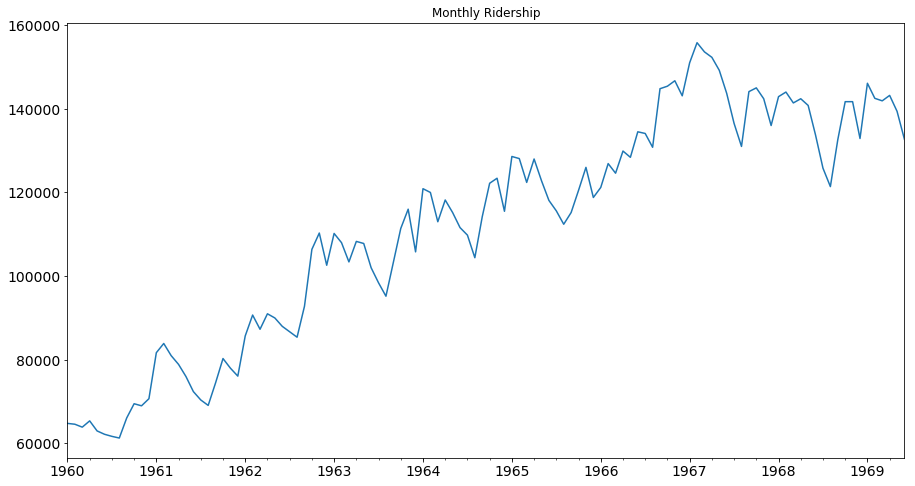

In [15]:
ts = df.riders
ts.plot(figsize = (15, 8), title = 'Monthly Ridership', fontsize = 14)

## Seasonality Check:

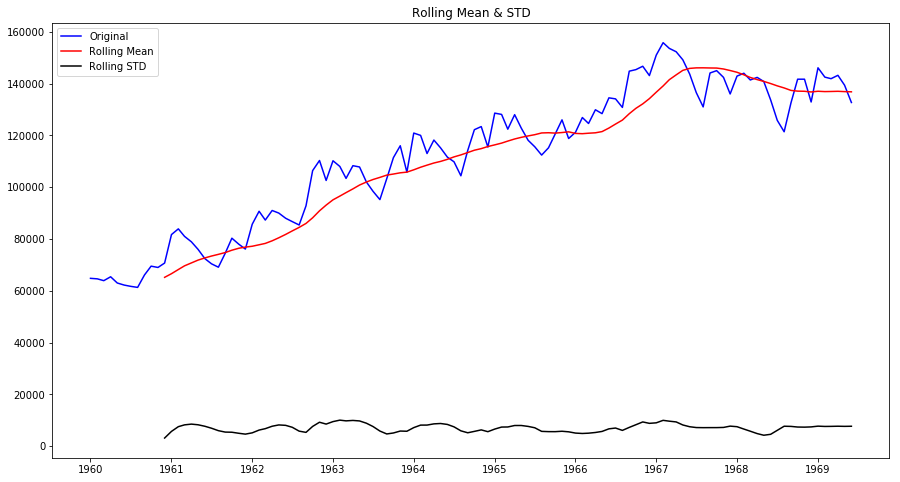

In [16]:
plotRollingMeanSTD(ts, 12)

In [17]:
DickeyFullerTest(ts)

Results of Dickey-Fuller Test:
Test Statistic:          -1.536597
p-value:                  0.515336
Lag No.:                 12.000000
Observation No.:        101.000000
Critical Value (5%)      -2.890611
Critical Value (1%)      -3.496818
Critical Value (10%)     -2.582277
dtype: float64


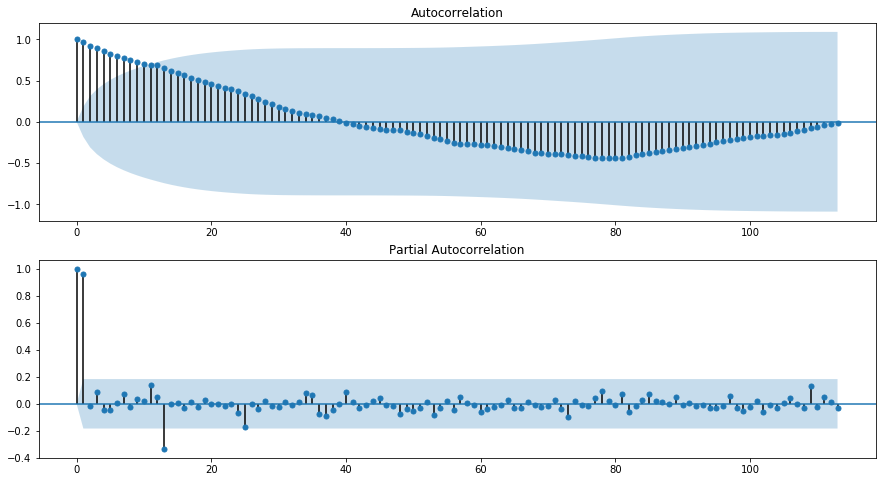

In [18]:
plotACFandPACF(ts)

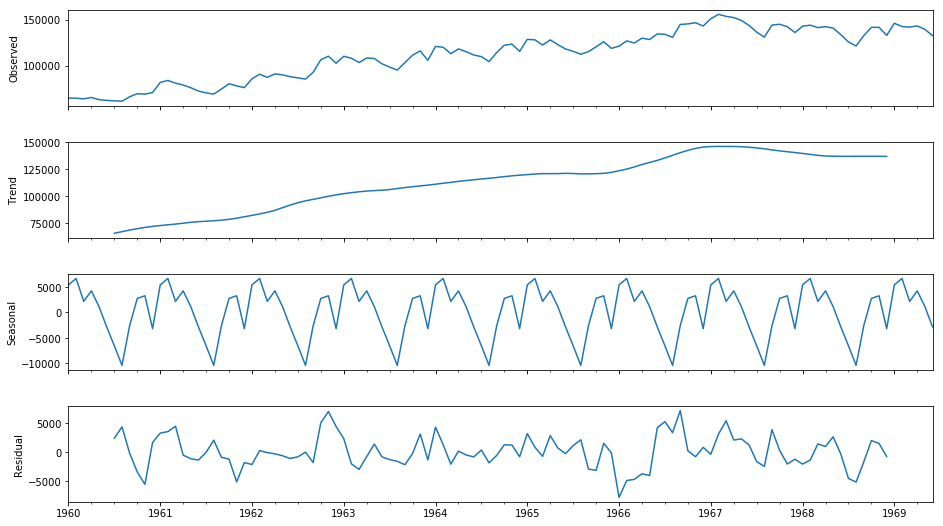

In [20]:
d1 = decomposSeasonality(ts)

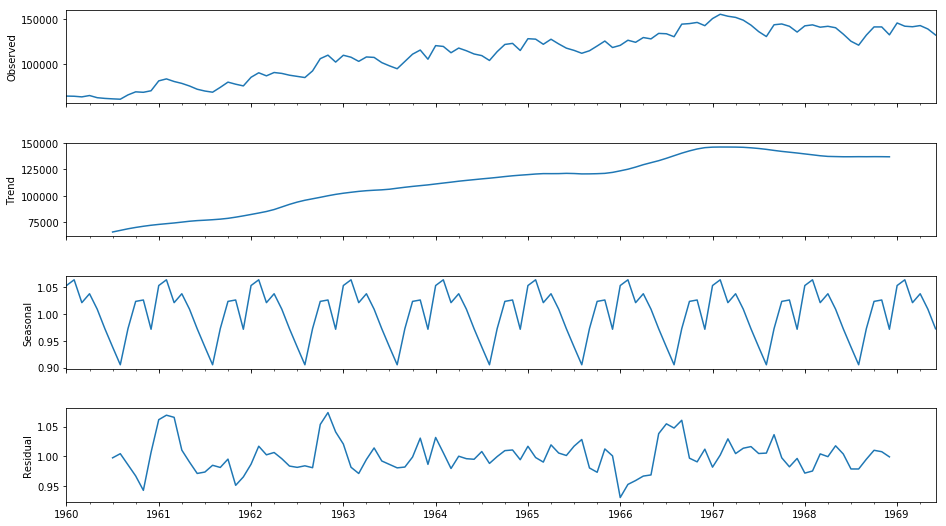

In [21]:
d2 = decomposSeasonality(ts, "multiplicative")

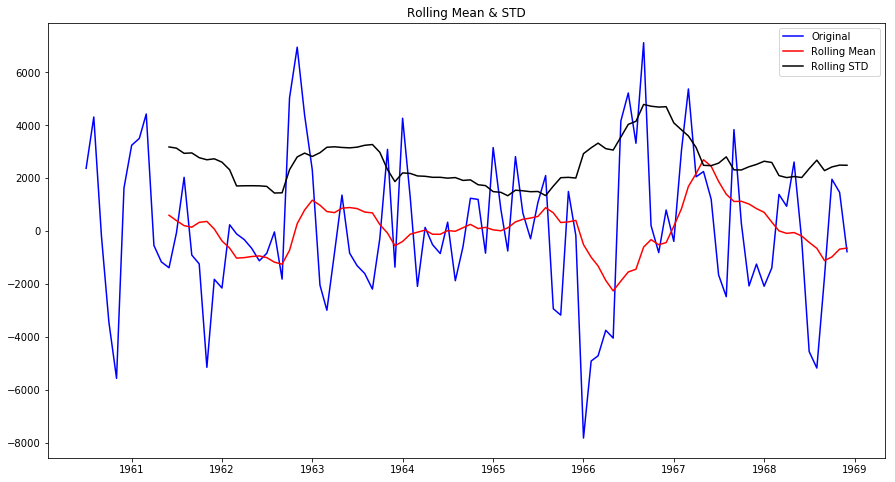

In [22]:
plotRollingMeanSTD(d1.resid, 12)

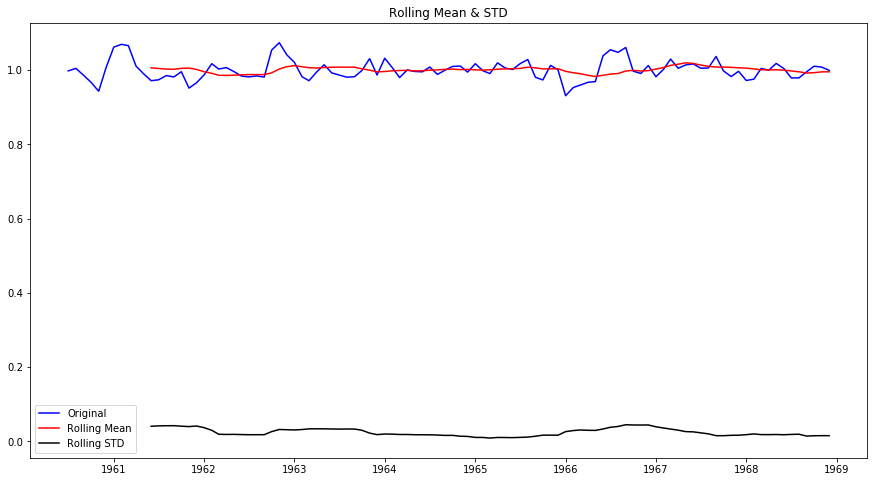

In [23]:
plotRollingMeanSTD(d2.resid, 12)

In [24]:
DickeyFullerTest(d1.resid.dropna(inplace = False))
print
DickeyFullerTest(d2.resid.dropna(inplace = False))

Results of Dickey-Fuller Test:
Test Statistic:        -5.731921e+00
p-value:                6.570180e-07
Lag No.:                3.000000e+00
Observation No.:        9.800000e+01
Critical Value (5%)    -2.891516e+00
Critical Value (1%)    -3.498910e+00
Critical Value (10%)   -2.582760e+00
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic:        -6.472513e+00
p-value:                1.356110e-08
Lag No.:                3.000000e+00
Observation No.:        9.800000e+01
Critical Value (5%)    -2.891516e+00
Critical Value (1%)    -3.498910e+00
Critical Value (10%)   -2.582760e+00
dtype: float64


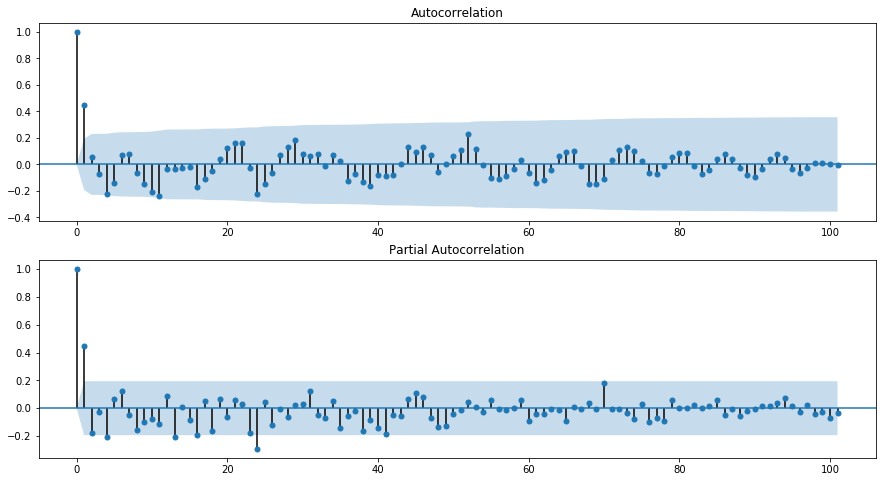

In [25]:
plotACFandPACF(d1.resid.dropna(inplace = False))

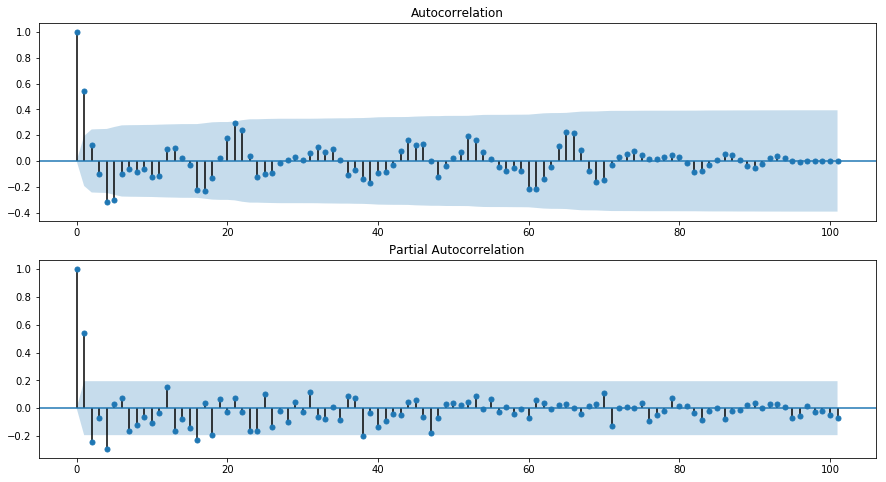

In [26]:
plotACFandPACF(d2.resid.dropna(inplace = False))

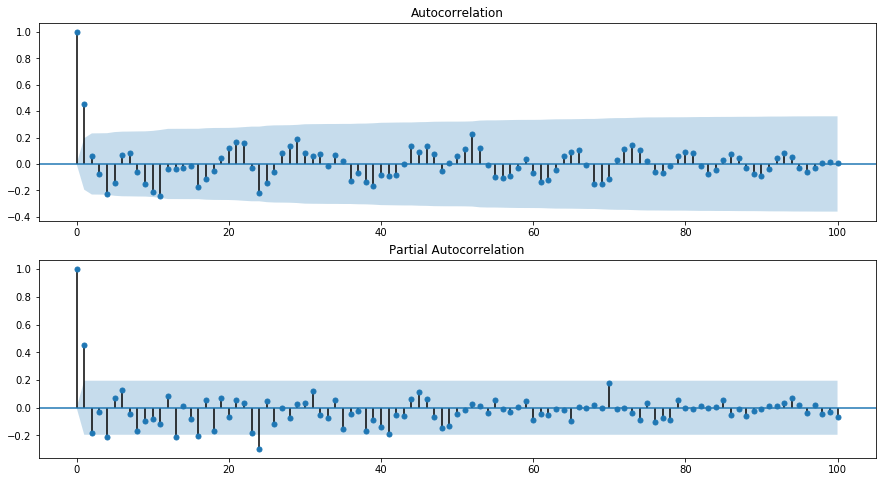

In [27]:
d3 = d1.resid.dropna(inplace = False).shift()
#d2.resid.shift = d2.resid - d2.resid.shift()
plotACFandPACF(d3.dropna(inplace=False))

Differeing with shift function does not help that means ARIMA(p,0,q) and ARIMA(p, 1, q) are the same

In [38]:
from statsmodels.tsa.arima_model import ARIMA

model_d1 = ARIMA(d1.resid.dropna(inplace = False), order = (3,0,3))
result_d1 = model_d1.fit(disp = -1)
print result_d1.summary()

                              ARMA Model Results                              
Dep. Variable:                 riders   No. Observations:                  102
Model:                     ARMA(3, 3)   Log Likelihood                -934.363
Method:                       css-mle   S.D. of innovations           2250.407
Date:                Mon, 20 Mar 2017   AIC                           1884.726
Time:                        16:27:39   BIC                           1905.725
Sample:                    07-01-1960   HQIC                          1893.229
                         - 12-01-1968                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           54.7659    379.143      0.144      0.885      -688.341   797.873
ar.L1.riders     0.4839      0.191      2.528      0.013         0.109     0.859
ar.L2.riders    -0.7128      0.152     -4.70

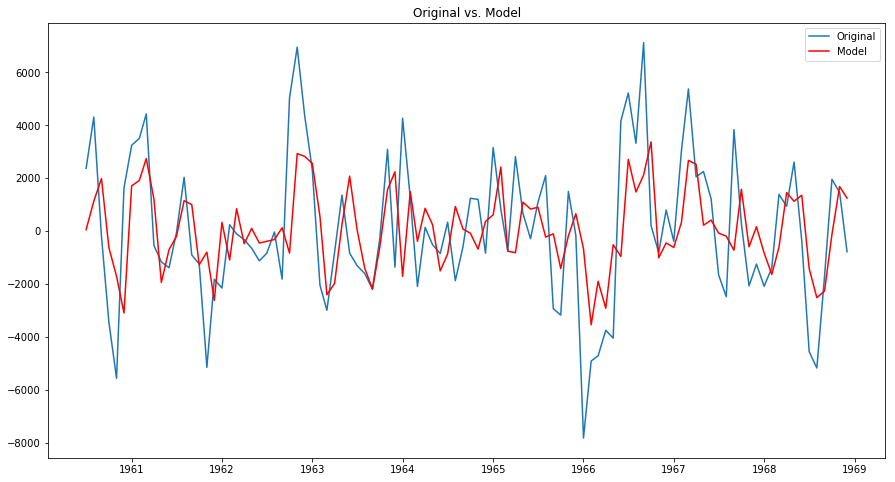

In [39]:
fig = plt.figure(figsize = (15, 8))
plt.plot(d1.resid.dropna(inplace = False), label = 'Original')
plt.plot(result_d1.fittedvalues, color = 'red', label = 'Model')
plt.legend(loc = 'best')
plt.title('Original vs. Model')
plt.show()

## Procedure to find Prediction Trend:

In [46]:
d1_trend = d1.trend.dropna(inplace = False)

print d1_trend.index[0]
print d1_trend.index[len(d1_trend) - 1]

1960-07-01 00:00:00
1968-12-01 00:00:00


### First Example

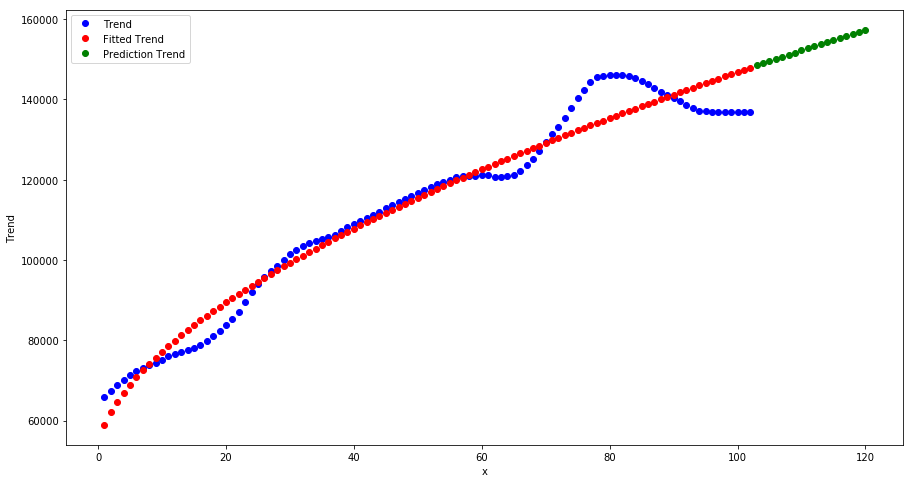

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * pow(x, b) + c

y = d1_trend.values
x = np.linspace(1, len(y), len(y))

n_p = 18
len_ys = len(y) + n_p

xs = np.linspace(1, len_ys, len_ys)

popt, pcov = curve_fit(func, x, y)

xp = np.linspace(len(y)+1, len_ys, n_p)

fig = plt.figure(figsize = (15, 8))
plt.plot(x, y, 'bo', label = 'Trend')
plt.plot(x, func(x, *popt), 'ro', label = 'Fitted Trend')
yp = func(xp, *popt)
plt.plot(xp, yp, 'go', label='Prediction Trend')

plt.xlabel('x')
plt.ylabel('Trend')
plt.legend(loc = 'best')
plt.show()

### Second Example

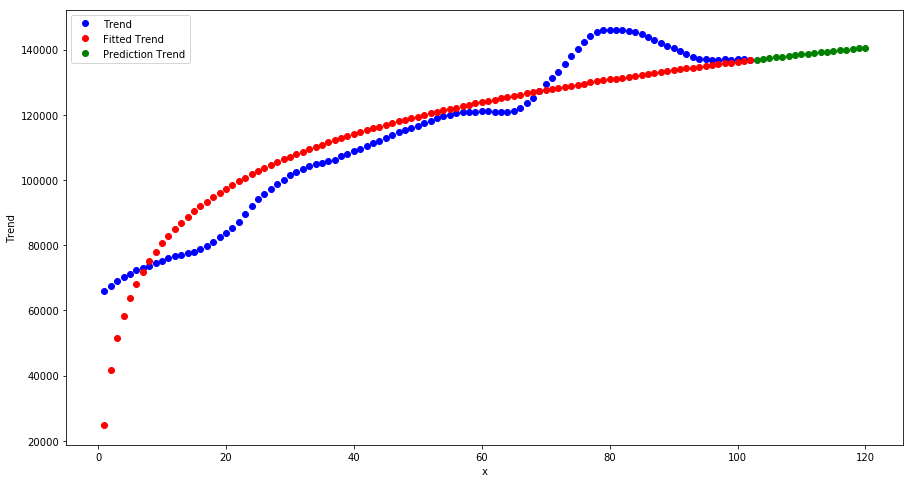

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(x) + c

y = d1_trend.values
x = np.linspace(1, len(y), len(y))

n_p = 18
len_ys = len(y) + n_p

xs = np.linspace(1, len_ys, len_ys)

popt, pcov = curve_fit(func, x, y)

xp = np.linspace(len(y)+1, len_ys, n_p)

fig = plt.figure(figsize = (15, 8))
plt.plot(x, y, 'bo', label = 'Trend')
plt.plot(x, func(x, *popt), 'ro', label = 'Fitted Trend')
yp = func(xp, *popt)
plt.plot(xp, yp, 'go', label='Prediction Trend')

plt.xlabel('x')
plt.ylabel('Trend')
plt.legend(loc = 'best')
plt.show()

In [63]:
start = datetime.datetime.strptime("1960-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months = x) for x in range(0, 120)]
d1_trend_predict = pd.Series(np.array(y.tolist() + yp.tolist()), index = pd.DatetimeIndex(date_list))
d1_trend_predict.name = "riders"

## Calculating the Residual Prediction:

In [62]:
d1_resid_perdict = result_d1.predict(start = '1960-07-01', end = '1970-06-01')
d1_resid_perdict.name = "riders"

## Calculating the Residual Prediction:

In [81]:
start = datetime.datetime.strptime("1969-07-01", "%Y-%m-%d")
date_tmp = [start + relativedelta(months = x) for x in range(0, 12)]

seasonLength = len(d1.seasonal)
values_tmp = list(d1.seasonal.values[(seasonLength-12):seasonLength])

d1_seasonal_tmp = pd.Series(np.array(values_tmp), index = pd.DatetimeIndex(date_tmp))
d1_seasonal_tmp.name = "riders"
d1_seasonal = d1.seasonal
d1_seasonal_predict = d1_seasonal.append(d1_seasonal_tmp)

## Plot the Time Series Forecast:

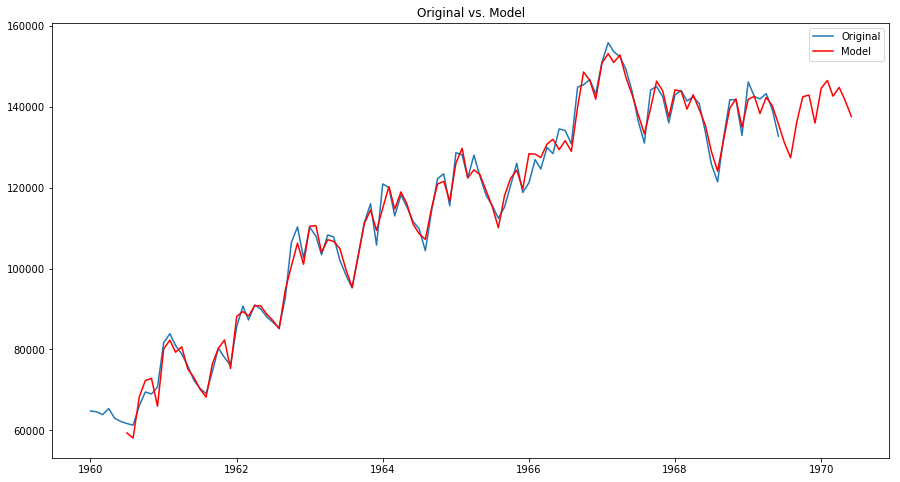

In [76]:
fig = plt.figure(figsize = (15, 8))

plt.plot(ts, label = 'Original')
d1_predict = d1_trend_predict + d1_seasonal_predict + d1_resid_perdict

plt.plot(d1_predict, color = 'red', label = 'Model')
plt.legend(loc = 'best')
plt.title('Original vs. Model')
plt.show()